## TIMESTACK PER LE LINEE DI RIVA DI SIROLO

In [14]:
import pandas as pd
import numpy as np
import os
import geopandas as gp
import datetime as dt
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import fiona
from shapely.wkt import loads



<font color=blue>**Definiamo le direzzioni e le variabili necessarie**<font>

In [15]:
dir_SH = '/Users/paolasouto/Desktop/DOTTORATO/python/FotoCamera_Sirolo_proves/'
filename_SH = 'Shorelines_shapefiles.csv'

<font color=blue>**Carichiamo i dati con le shoreline**<font>

In [16]:
for filename in [item for item in os.listdir(dir_SH) if item[-3:]=='csv']:
    if filename == filename_SH:
        SHs = gp.read_file(os.path.join(dir_SH, filename))
        #gp.GeoDataFrame(SHs, geometry='geometry')
SHs.columns = ['OBJECTID', 'UNCERTAINT', 'SHAPE_Leng', 'geometry', 'Datetime','drop']
SHs.drop('drop', axis=1, inplace = True)


SHs['geometry'] = SHs['geometry'].apply(loads)

In [17]:
SHs.crs = fiona.crs.from_epsg(32633) # Stabiliamo il crs


In [18]:
# Convertiamo a timestamps le ore, in modo che python sappia che è in formato UTC

SHs['Datetime2'] = pd.to_datetime(SHs['Datetime'], utc = True)
SHs.drop(['Datetime'], axis=1, inplace=True)
SHs.columns = ['OBJECTID', 'UNCERTAINT', 'SHAPE_Leng', 'geometry', 'Datetime']

In [19]:
SHs = SHs[:-1]

<font color=blue>**Percorriamo ogni Sh per vedere la lunghezza di ogn'una di loro**<font>

* <font color=blue>Per studiare gli spostamenti mare/terra, dobbiamo guardare la posizione 
    crosshore, che in questo caso è x<font>
* <font color=blue>La lunghezza delle shoreline viene analizzata nel asso y<font>

In [20]:
vec_fecha = []
blim_com_t = [] 
blim_fin_t = []

for i in range(len(SHs)):
    shoreline_inf = SHs.iloc[i,:]
    sh = pd.DataFrame(shoreline_inf['geometry'].coords, columns = ['cross', 'along']) # 
    aI_a = sh['along'].iloc[0]
    aF_a = sh['along'].iloc[-1]
    blim_com_t.append(aI_a)
    blim_fin_t.append(aF_a)
    vec_fecha.append(shoreline_inf['Datetime'].date())


In [21]:
max_lonf = np.max(blim_fin_t)
min_lonf = np.min(blim_fin_t)
max_loni = np.max(blim_com_t)
min_loni = np.min(blim_com_t)

<font color=blue>**Stabiliamo come determinare il numero di NaN a aggiungere a quelle più corte**<font>

* <font color=blue>1) Stabiliamo la benchmark<font>

In [22]:
bench = np.linspace(min_loni-50, max_lonf+50, 150) #
x_bench = [388604.374069 - 80]*len(bench)

* <font color=blue>2) Dobbiamo fare l'interpolazione della benchmark per stabilire le distanze a quei punti per ogni shoreline<font>

In [23]:
xd = np.diff(x_bench)
yd = np.diff(bench)
dist = np.sqrt(xd**2+yd**2)
u = np.cumsum(dist)
u = np.hstack([[0],u])

t = np.linspace(0,u.max(),100) # Con 20 ptos evaluamos cada 60 m, con 30 c 40 m
xn = np.interp(t, u, x_bench)
yn = np.interp(t, u, bench)

(array([388500., 388520., 388540., 388560., 388580., 388600., 388620.,
        388640., 388660., 388680., 388700.]),
 <a list of 11 Text xticklabel objects>)

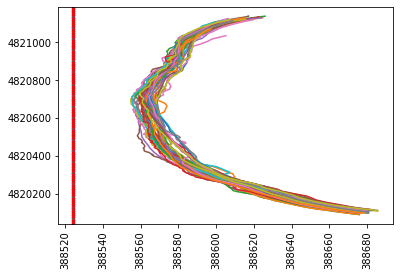

In [33]:
# hacemos el plot del bench y de todas las shorelines
f = plt.figure()
ax = f.add_subplot(111)
ax.plot(x_bench,bench,'o', alpha=0.5, markersize=3)
ax.plot(xn,yn,'ro', markersize=2)
for i in range(len(SHs)):
    shoreline_inf = SHs.iloc[i,:]
    sh = pd.DataFrame(shoreline_inf['geometry'].coords, columns = ['cross', 'along']) 
    plt.plot(sh['cross'], sh['along'])
    plt.ylim([min_loni-50, max_lonf+50])

plt.xticks( rotation='vertical')


<font color=blue>**Calcoliamo Y(t,x) che sono le distanze di ogni shoreline ai punti della benchmark**<font>

* <font color=blue>3) Facciamo l'interpolazione sui valori y della benchmarck per ogni shoreline<font>
* <font color=blue>4) Calcoliamo la distanza tra ogni punto interporlato della shoreline e la benchmark<font>
* <font color=blue>5) Generiamo un pandasDataFrame dove ogni colonna ha tutte le distanze di ogni shoreline ai punti della benchmarck<font>

In [25]:
UNDEF = np.nan # Definiamo il valore da mettere a destra e sinistra qundo nella sh non c'è il pto
matcr = pd.DataFrame() # si inizializa il pandasDataFrame
o = 0
for i in range(len(SHs)):
    o +=1
    shoreline_inf = SHs.iloc[i,:]
    sh = pd.DataFrame(shoreline_inf['geometry'].coords, columns = ['cross', 'along']) 
    Xinterp = np.interp(yn, sh['along'], sh['cross'], left=UNDEF, right=UNDEF) # 3) Interpo
    dist_x = pd.DataFrame(Xinterp-xn) # 4) Calcolo delle distanze alla benchmark
    matcr = pd.concat([matcr, dist_x], axis=1) # 5) Generiamo il pandasDataFrame

numbers = list(range(len(matcr.columns)))
matcr.columns = numbers

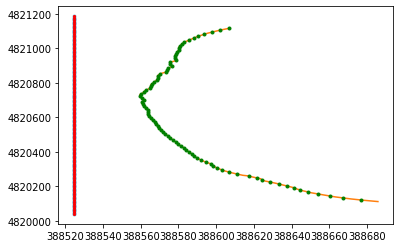

In [26]:
f = plt.figure()
ax = f.add_subplot(111)
ax.plot(x_bench,bench,'o', alpha=0.5, markersize=3)
ax.plot(xn,yn,'ro', markersize=2)
ax.plot(sh['cross'], sh['along'])
ax.plot(Xinterp,yn, 'g.')

<font color=blue>**Calcoliamo Yx(t) = la posizione media crosshore delle SH que si posiedono**<font>

In [27]:
crossme = matcr.mean(axis=1)
crossme = pd.DataFrame(crossme)

<font color=blue>**Calcoliamo Dx(t,x), che è la matrice Deviazione**<font>

In [28]:
matD = pd.DataFrame()
for j in range(len(matcr.columns)):
    desv = pd.DataFrame(matcr.iloc[:,j] - crossme.T)
    matD = pd.concat([matD, desv], axis=0)
matD.reset_index(drop=True, inplace=True)

<font color=blue>**Definiamo le date in qui sono stati realizatti i ripascimenti**<font>

In [29]:
Ripascimenti = ['2010-04-06','2010-04-07', '2010-04-08','2010-04-14','2010-04-21','2010-04-22',
                '2010-04-23','2010-04-26','2010-04-27','2010-04-28','2010-04-29',
                '2010-04-30','2010-05-07','2010-05-08','2010-05-10','2010-05-11',
                '2010-05-12','2010-05-13','2010-11-24','2010-11-25','2010-11-26',
                '2011-01-05','2011-01-07','2011-01-08','2011-01-10','2011-01-12',
                '2011-01-14','2011-01-16','2011-01-18','2011-01-20','2011-01-22',
                '2011-01-24','2011-01-26','2011-01-28']

Ripas = []
for time in Ripascimenti:
    Ripas.append(dt.datetime.strptime(time, '%Y-%m-%d').date())

    
events_idx = [[1,11], [12,17], [18,20], [21,-1]]


################################################ T in which there is a gap of images
    
T_off_camears = ['2010-11-29', '2010-12-13']

TOff = []

for day in T_off_camears:
    TOff.append(dt.datetime.strptime(day, '%Y-%m-%d').date())
    




Text(-0.03, -0.6, 'Retreat')

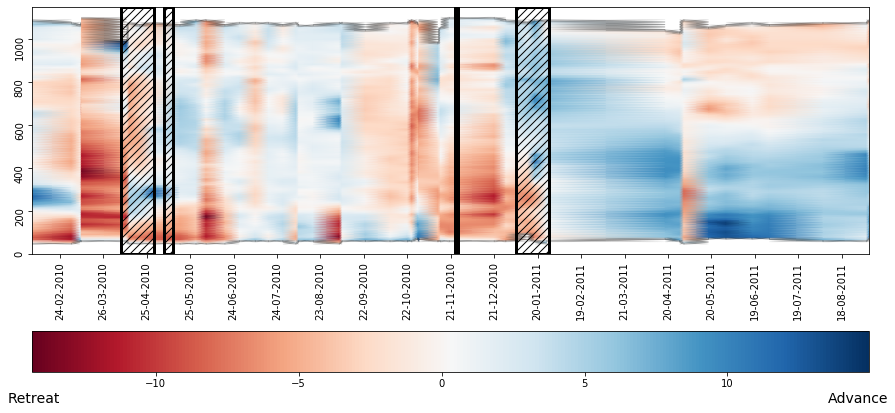

In [31]:
import matplotlib.dates as mdates 
import matplotlib.ticker as tkr
from matplotlib.patches import Rectangle

## La stessa dimensione per pcolor
xx=np.arange(0,len(SHs))
yy=np.arange(0, len(yn))
vec_dist = np.linspace(0,(max_lonf+50)-(min_loni-50), len(yn)).astype(int)

## Definiamo gli x e gli y label

xx2 = xx[::4] # Take data each 4nth position
vec_fecha2 = vec_fecha[::4]
yy2 = yy[::10]
vec_dist2 = vec_dist[::10]



fig = plt.figure(figsize=(15,7))
ax = plt.gca()


### Rettangoli segnalando i ripascimenti

for idx in events_idx:
    start = mdates.date2num(Ripas[idx[0]])
    end = mdates.date2num(Ripas[idx[1]])
    width = int(end - start)
    rect = Rectangle((start, 0), width, vec_dist[-1], fill = False, edgecolor ='k'
                     , linewidth = 3, hatch='///')
    ax.add_patch(rect)
    

### Rettangolo segnalando il gap di immagini

startOff = mdates.date2num(TOff[0])
endOff = mdates.date2num(TOff[1])
widthOff = int(endOff-startOff)
rectOff = Rectangle((startOff, 0), widthOff, vec_dist[-1], fill = False, 
                    edgecolor = 'r', linewidth = 3)
#ax.add_patch(rectOff)


cax = plt.pcolormesh(vec_fecha, vec_dist,matD.T, cmap='RdBu',shading='gouraud') #


    
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
#ax.xaxis.set_minor_formatter(mdates.DateFormatter('%d-%m-%Y'))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=30))
#ax.xaxis.set_minor_locator(mdates.DayLocator(interval=100))
#ax.tick_params(which='minor', length=4, color='r', labelcolor='r', rotation =90) # 
ax.tick_params(which='major', length=4, color='k', labelcolor='k', rotation =90) # 



#ax.xaxis.set_minor_formatter(mdates.DateFormatter('%d-%m-%Y'))
#ax.axis.set_minor_locator(mdates.DayLocator(interval=100))


#ax2.set_xticks(xx[5])
#ax2.set_xticklabels(vec_fecha[5], color='red')

#ax.get_xticklabels()[3].set_color("red") #  Este es un modo para cambiar el color de las fechas
                                         #  ya etiquetadas 
    
#plt.gcf().autofmt_xdate(rotation=30) # to rotate

 
cbar = fig.colorbar(cax, orientation='horizontal', pad=0.2)
plt.text(0.95, -0.6, 'Advance', fontsize=14, transform=ax.transAxes)
plt.text(-0.03, -0.6, 'Retreat', fontsize=14, transform=ax.transAxes)




<font color=blue>**Plottiamo i parametri ondametrici della boa di Ancona per lo stesso periodo temporale**<font>

In [35]:
dir_waves = '/Users/paolasouto/Desktop/DOTTORATO/ONDAMETRIA/ONDAMETRIA_ANCONA/'
folders = ['Hs', 'Tp', 'Dir']
T_interest = [SHs['Datetime'][0], SHs['Datetime'][len(SHs)-1]]

<font color=blue>Funzione per leggere le date dei file che contengono i dati ondametrici<font>

In [36]:
import pytz
def ToDates(filename):
        
    start_t, end_t, suff = filename.split('_')
    start_t = dt.datetime.strptime(start_t, '%Y-%m-%d')
    start_t = pytz.timezone('UTC').localize(start_t)
    end_t = dt.datetime.strptime(end_t, '%Y-%m-%d')
    end_t = pytz.timezone('UTC').localize(end_t)
    return start_t, end_t, suff

<font color=blue>Genriamo il pandasDataFrame che contiene tutti i dati di 2010 e 2011<font>

In [37]:
folders = ['Hs', 'Tp', 'Dir']

df_Hs = pd.DataFrame()
df_Tp = pd.DataFrame()
df_Dir = pd.DataFrame()

for folder in folders:
    dir_variable = os.path.join(dir_waves, folder)
    for filename in [item for item in os.listdir(dir_variable) if item[-3:]=='csv']:
        start_t, end_t, suff = ToDates(filename)
        df = pd.read_csv(os.path.join(dir_variable, filename))
        if suff == 'Dir.csv':
            df_Dir = pd.concat([df_Dir, df], axis=0)
        if suff == 'Tp.csv':
            df_Tp = pd.concat([df_Tp, df], axis=0)
        if suff == 'Hs.csv':
            df_Hs = pd.concat([df_Hs, df], axis=0)

df_Dir.reset_index(drop=True, inplace=True)
df_Tp.reset_index(drop=True, inplace=True)
df_Hs.reset_index(drop=True, inplace=True)

<font color=blue>Convertiamo a datetime le stringhe corrispondenti alle date<font>

In [38]:
df_Dir['Inizio validità (UTC)'] = pd.to_datetime(df_Dir['Inizio validità (UTC)'], utc=True)
df_Dir['Fine validità (UTC)'] = pd.to_datetime(df_Dir['Fine validità (UTC)'], utc=True)

df_Tp['Inizio validità (UTC)'] = pd.to_datetime(df_Tp['Inizio validità (UTC)'], utc=True)
df_Tp['Fine validità (UTC)'] = pd.to_datetime(df_Tp['Fine validità (UTC)'], utc=True)

df_Hs['Inizio validità (UTC)'] = pd.to_datetime(df_Hs['Inizio validità (UTC)'], utc=True)
df_Hs['Fine validità (UTC)'] = pd.to_datetime(df_Hs['Fine validità (UTC)'], utc=True)

<font color=blue>Facciamo la selezione dei dati che appartengono al T desiderato<font>

In [39]:
Dir_values = df_Dir[(df_Dir['Inizio validità (UTC)']>=T_interest[0]) & (df_Dir['Inizio validità (UTC)']<=T_interest[1])]
Tp_values = df_Tp[(df_Tp['Inizio validità (UTC)']>=T_interest[0]) & (df_Tp['Inizio validità (UTC)']<=T_interest[1])]
Hs_values = df_Hs[(df_Hs['Inizio validità (UTC)']>=T_interest[0]) & (df_Hs['Inizio validità (UTC)']<=T_interest[1])]

<font color=blue>Facciamo i plot<font>

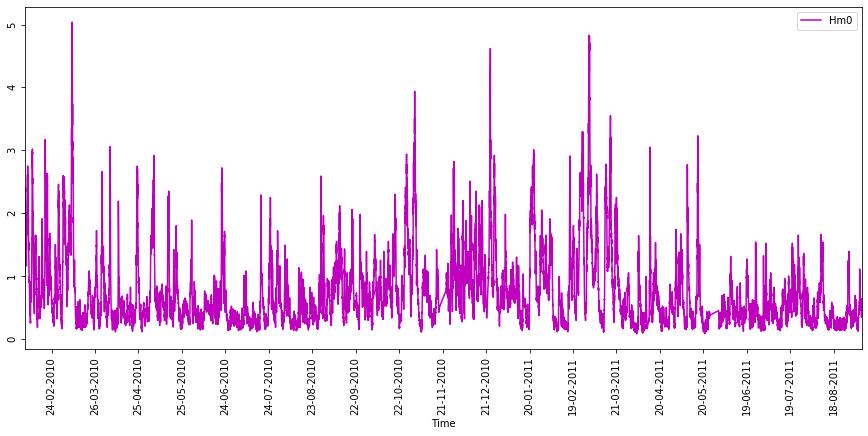

In [47]:
fig = plt.figure(figsize=(15,7))
ax = plt.gca()


Hs_values.plot(ax=ax,x='Inizio validità (UTC)',y='Hm0',color='m', xticks=[])
plt.xlabel('Time')
#axs[0].set_xlabel("")
#Tp_values.plot(ax=axs[1],x='Inizio validità (UTC)',y='Tp',color='c', xticks=[])
#axs[1].set_xlabel("")
#Dir_values.plot(ax=axs[2],x='Inizio validità (UTC)',y='Dir',color='k')

ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=30))
ax.tick_params(which='major', length=4, color='k', labelcolor='k', rotation =90) # 




In [132]:
SHs['Datetime']

0    2010-02-05 11:00:00+00:00
1    2010-03-04 14:00:00+00:00
2    2010-03-10 16:00:00+00:00
3    2010-03-11 13:00:00+00:00
4    2010-03-11 14:00:00+00:00
5    2010-04-11 13:00:00+00:00
6    2010-04-13 12:00:00+00:00
7    2010-04-20 14:00:00+00:00
8    2010-04-29 12:00:00+00:00
9    2010-05-18 12:00:00+00:00
10   2010-05-29 10:00:00+00:00
11   2010-06-05 12:00:00+00:00
12   2010-06-18 06:00:00+00:00
13   2010-06-28 10:00:00+00:00
14   2010-07-09 15:00:00+00:00
15   2010-07-18 05:00:00+00:00
16   2010-07-28 09:00:00+00:00
17   2010-08-06 09:00:00+00:00
18   2010-08-08 07:00:00+00:00
19   2010-08-18 09:00:00+00:00
20   2010-09-05 15:00:00+00:00
21   2010-09-07 08:00:00+00:00
22   2010-09-23 15:00:00+00:00
23   2010-10-10 15:00:00+00:00
24   2010-10-22 15:00:00+00:00
25   2010-10-25 07:00:00+00:00
26   2010-10-29 16:00:00+00:00
27   2010-10-30 07:00:00+00:00
28   2010-10-30 16:00:00+00:00
29   2010-11-12 14:00:00+00:00
30   2010-11-14 13:00:00+00:00
31   2010-11-20 14:00:00+00:00
32   201